# Notebook with Python implementations of known TSCH Scheduling Functions

SF format:
- input: connectivity matrix, topology
- output: scheduled cells

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random
from tqdm.auto import tqdm
import h5py

# Define your own color palette
custom_palette = ["#FFFFFF","#DAE8FC", "#D5E8D4", "#FFE6CC", "#FFF2CC", "#F8CECC", "#E1D5E7"]
# Create a colormap with smoothly varying colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette)

## Implemented SFs
- TASA

### TASA

https://ieeexplore.ieee.org/abstract/document/6362805
 - should we vary connectivity or traffic?

In [2]:
# 1. find matrices q and Q
# 2. implement matching to find the DCFL
# 3. get interference conflict graph
# 4. implement coloring
# 5. update matrices q and Q based on scheduled links on current slot

In [3]:
# defines
NUM_NODES = 13
NUM_TIMESLOTS = 70
NUM_CHANNELS = 6

# TODO nodes traffic

In [4]:
# classes

class Node:
    def __init__(self, node_id: int, q: int):
        self.id = node_id
        self.q = q
        self.timeslots = []
        self.channels = []

class Tree:
    def __init__(self, root: Node):
        self.root = root
        self.subtrees_list = []
        self.children_list = []
        self.valid = False

    def print_tree_info(self):
        print("Root:", self.root.id)
        print("Children:")
        for child in self.children_list:
            print(" -", child.id)
        print("Subtrees:")
        for subtree in self.subtrees_list:
            print(" - Subtree with root:", subtree.root.id)
        print(f"Valid: {self.valid}")

class Link:
    def __init__(self, source, destination):
        self.source = source
        self.destination = destination

    def print_link_info(self):
        print(f"Link Node {self.source.id} -> Node {self.destination.id}")

class Timeslot:
    def __init__(self, time, frequency, type, neighbor: Node):
        self.time = time
        self.frequency = frequency
        self.type = type
        self.neighbor = neighbor
    def print_timeslot_info(self):
        print(f"timeslot num = {self.time}")
        print(f"assigned channel offset = {self.frequency}")
        print(f"timeslot type {self.type} with neighbor {self.neighbor.id}")

In [5]:
# helpers

def get_subtree(tree: Tree, root: Node):
    if tree.root.id == root.id:
        return tree
    else:
        for subtree in tree.subtrees_list:
            sub_tree = get_subtree(subtree, root)

            if sub_tree != None:
                return sub_tree
    return None

def get_nodes_in_tree(tree: Tree):
    nodes_list = []

    # add root
    nodes_list += [tree.root]

    # add children in subtrees (if any)
    for subtree in tree.subtrees_list:
        nodes_list += get_nodes_in_tree(subtree)

    return nodes_list


def calculate_Q(node: Node, k, q, tree: Tree):

    subtree = get_subtree(tree, node)

    # get total Q on subtree
    nodes_in_tree = get_nodes_in_tree(subtree)

    total_Q = 0
    for n in nodes_in_tree:
        total_Q += q[n.id,k]

    return total_Q

def get_valid_children(tree: Tree):
    valid_children_list = []

    for subtree in tree.subtrees_list:
        if subtree.valid:
            valid_children_list += [subtree]

    return valid_children_list

def print_DCFL(DCFL, k):
    print("Duplex Conflict Free Link list for timeslot", k)
    for link in DCFL:
        link.print_link_info()

def get_conflicting_nodes(node_id, last_node_id, nodes_list, interference_matrix, channel, hops):
    n_nodes = len(nodes_list)

    # create new list
    list = []

    if hops==1:
        # insert all nodes that interfere with you directly
        for i in range(n_nodes):
            if interference_matrix[node_id,i,channel]==1 and i!=last_node_id:
                list += [nodes_list[i]]
    else:
        # look for all neighbors that interfere with you
        for i in range(n_nodes):
            if interference_matrix[node_id,i,channel]==1 and i!=last_node_id:
                n1 = nodes_list[i]

                # insert current node into the list if it is not there yet
                if n1 not in list:
                    list += [n1]
                list_neighbor = get_conflicting_nodes(i, node_id, nodes_list, interference_matrix, channel, hops-1)

                for n2 in list_neighbor:
                    if n2.id!=node_id and n2 not in list:
                        list += [n2]

    return list

def create_interference_matrix(links):
    # init empty matrix
    interference_matrix = np.zeros((NUM_NODES, NUM_NODES, NUM_CHANNELS))

    for c in range(NUM_CHANNELS):
        for link in links:
            interference_matrix[link.source.id,link.destination.id,c] = 1
            interference_matrix[link.destination.id,link.source.id,c] = 1

    return interference_matrix

def create_conflict_matrix(interference_matrix, nodes_list):
    # init empty matrix
    conflict_matrix = np.zeros((NUM_NODES, NUM_NODES, NUM_CHANNELS))

    n_nodes = len(nodes_list)

    for c in range(NUM_CHANNELS):
        for i in range(n_nodes):
            # get list of conlifcting nodes
            conflicting_nodes = get_conflicting_nodes(i,i,nodes_list,interference_matrix,c,5)
            nodes_ids = [node.id for node in conflicting_nodes]
            for conflicting_node in conflicting_nodes:
                conflict_matrix[i,conflicting_node.id,c] = 1

    return conflict_matrix

def validate_all_subtrees(tree: Tree):
    tree.valid = True

    for subtree in tree.subtrees_list:
        validate_all_subtrees(subtree)

def init_network_tree(nodes, database=False):
    
    # create main tree and subtrees
    tree = Tree(nodes[0])
    subtree_1 = Tree(nodes[1])
    subtree_2 = Tree(nodes[2])
    subtree_3 = Tree(nodes[3])
    subtree_4 = Tree(nodes[4])
    subtree_5 = Tree(nodes[5])
    subtree_6 = Tree(nodes[6])
    subtree_7 = Tree(nodes[7])
    subtree_8 = Tree(nodes[8])
    subtree_9 = Tree(nodes[9])
    subtree_10 = Tree(nodes[10])
    subtree_11 = Tree(nodes[11])
    subtree_12 = Tree(nodes[12])
    
    # populate children and subtrees
    tree.children_list += [nodes[1]]
    tree.children_list += [nodes[2]]
    tree.children_list += [nodes[3]]
    tree.children_list += [nodes[4]]
    
    tree.subtrees_list += [subtree_1]
    tree.subtrees_list += [subtree_2]
    tree.subtrees_list += [subtree_3]
    tree.subtrees_list += [subtree_4]
    tree.subtrees_list += [subtree_5]
    tree.subtrees_list += [subtree_6]
    tree.subtrees_list += [subtree_7]
    tree.subtrees_list += [subtree_8]
    tree.subtrees_list += [subtree_9]
    tree.subtrees_list += [subtree_10]
    tree.subtrees_list += [subtree_11]
    tree.subtrees_list += [subtree_12]
    
    subtree_1.children_list += [nodes[5]]
    subtree_1.children_list += [nodes[6]]
    
    subtree_1.subtrees_list += [subtree_5]
    subtree_1.subtrees_list += [subtree_6]
    subtree_1.subtrees_list += [subtree_11]
    
    subtree_2.children_list += [nodes[7]]
    
    subtree_2.subtrees_list += [subtree_7]
    
    subtree_3.children_list += [nodes[8]]
    subtree_3.children_list += [nodes[9]]
    
    subtree_3.subtrees_list += [subtree_8]
    subtree_3.subtrees_list += [subtree_9]
    subtree_3.subtrees_list += [subtree_12]
    
    subtree_4.children_list += [nodes[10]]
    
    subtree_4.subtrees_list += [subtree_10]
    
    subtree_5.children_list += [nodes[11]]
    
    subtree_5.subtrees_list += [subtree_11]
    
    subtree_8.children_list += [nodes[12]]
    
    subtree_8.subtrees_list += [subtree_12]

    return tree

In [6]:
# TASA helpers

def get_child_tasa_equation(q, Q, tree: Tree, ts):
    max_Q = 0
    node_max_Q = None

    for subtree in tree.subtrees_list:
        if subtree.valid:
            if q[subtree.root.id,ts] > 0:
                if Q[subtree.root.id,ts] > max_Q:
                    max_Q = Q[subtree.root.id,ts]
                    node_max_Q = subtree.root
    
    return node_max_Q

def tasa_matching(DCFL, q, Q, tree: Tree, k, nx: Node):
    subtree_nx = get_subtree(tree, nx)

    # for all children of root check if any satisfies TASA equation
    nj = get_child_tasa_equation(q, Q, subtree_nx, k)

    if nj != None:

        # create new link and add to DCFL
        DCFL += [Link(nj, nx)]

        subtree_nj = get_subtree(tree, nj)
        
        while (len(get_valid_children(subtree_nj)) > 0):

            # nz in children of nj
            subtree_nz = get_valid_children(subtree_nj)[0]
            nz = subtree_nz.root

            # remove nz as valid child
            subtree_nz.valid = False

            # run matching again
            DCFL = tasa_matching(DCFL, q, Q, tree, k, nz)

        # remove nj as valid child
        subtree_nj.valid = False
        
        while (len(get_valid_children(subtree_nx)) > 0):

            # nw in children of nx
            subtree_nw = get_valid_children(subtree_nx)[0]
            nw = subtree_nw.root

            # remove nw as valid child
            subtree_nw.valid = False

            # run matching again
            DCFL = tasa_matching(DCFL, q, Q, tree, k, nw)

    return DCFL

def tasa_coloring(nodes_scheduled, conflict_matrix, Q, ts, channel):
    max_color = 0

    # list that holds all nodes sorted by non-decreasing order of Q
    nodes_sorted = sorted(nodes_scheduled, key=lambda node: Q[node.id,ts])
    
    for node in nodes_scheduled:
        # clean up allocated channels for node
        node.channels = []

    for node_to_color in nodes_sorted:

        # color each node
        color = 0

        # check if there is any neighbor of ith node with this color
        found_color = False

        while(not found_color):
            old_color = color

            # look at nodes with conflict
            for n in nodes_sorted:
                if conflict_matrix[node_to_color.id,n.id,channel]==1:
                    if color in n.channels:
                        color += 1
                        break

            # if color wasnt changed, every node was evaluated and no problems were found
            if old_color==color:
                found_color = True

        # add right color to node
        node_to_color.channels += [color]

        if color>max_color:
            max_color = color

    return max_color

In [7]:
def main_tasa(nodes_list, links_list, network_tree: Tree, interference_matrix, conflict_matrix, channel,verbose=True):
    # total number of nodes in network
    n_nodes = len(nodes_list)

    # sink id
    sink_id = tree.root.id

    # get total traffic to schedule in slotframe
    total_Q = sum(node.q for node in nodes_list)

    # init matrix q that will hold the number of packets locally stored at node i during timeslot j
    q = np.zeros((n_nodes, NUM_TIMESLOTS))
    # qi(0) is node's i total traffic for the slotframe
    for node in nodes_list:
        q[node.id,0] = node.q

    # init matrix Q that will hold the number of packets globally stored at a subtree rooted at node i during timeslot j
    Q = np.zeros((n_nodes, NUM_TIMESLOTS))
    # 
    for node in nodes_list:
        Q[node.id,0] = calculate_Q(node, 0, q, network_tree)
        
    # init timeslot
    k = 0

    # main loop
    while q[sink_id,k] != total_Q:
        if verbose:
            print(f"Timeslot {k}")
            print("matrix q:")
            print(q)
            print("matrix Q:")
            print(Q)

        # init DCFL list
        DCFL = []

        # validate all subtrees
        validate_all_subtrees(tree)

        # matching
        DCFL = tasa_matching(DCFL, q, Q, network_tree, k, tree.root)

        # print current DCFL
        if verbose:
            print_DCFL(DCFL, k)

        # create list of transmitter nodes in this timeslot for coloring
        nodes_scheduled = []

        for link in DCFL:
            if link.source not in nodes_scheduled:
                nodes_scheduled += [link.source]

        # coloring
        max_color = tasa_coloring(nodes_scheduled, conflict_matrix, Q, k, channel)

        # remove links corresponding to colors larger than NUM_CHANNELS
        if max_color>NUM_CHANNELS:
            for link in DCFL:
                print(link.source.channels[0])
                if link.source.channels[0] >= NUM_CHANNELS:
                    # remove link
                    DCFL.remove(link)

        # convert list of links into a list of timeslot and insert into the corresponding node
        for link in DCFL:
            tx = link.source
            rx = link.destination

            tx.timeslots += [Timeslot(k+1, tx.channels[0], 'TS_TX', rx)]
            rx.timeslots += [Timeslot(k+1, tx.channels[0], 'TS_RX', tx)]

        # go to next timeslot
        k += 1

        # update q
        for i in range(n_nodes):
            q[i,k] = q[i,k-1]

        for link in DCFL:
            tx = link.source
            rx = link.destination

            q[tx.id,k] -= 1
            q[rx.id,k] += 1

        # update Q
        for node in nodes_list:
            Q[node.id,k] = calculate_Q(node, k, q, tree)

In [8]:
# test

nodes = []
    
# create nodes
for n in range(NUM_NODES):
    if n==0:
        nodes+=[Node(n,0)]
    else:
        nodes+=[Node(n,random.randint(1,5))]

# init network links
links_list = [Link(nodes[1],nodes[0]),
              Link(nodes[2],nodes[0]),
              Link(nodes[3],nodes[0]),
              Link(nodes[4],nodes[0]),
              Link(nodes[5],nodes[1]),
              Link(nodes[6],nodes[1]),
              Link(nodes[7],nodes[2]),
              Link(nodes[8],nodes[3]),
              Link(nodes[9],nodes[3]),
              Link(nodes[10],nodes[4]),
              Link(nodes[11],nodes[5]),
              Link(nodes[12],nodes[8])]

# init network tree
tree = init_network_tree(nodes, database=False)

# create matrices
interference_matrix = create_interference_matrix(links_list)
conflict_matrix = create_conflict_matrix(interference_matrix, nodes)

main_tasa(nodes,links_list,tree,interference_matrix,conflict_matrix,0, verbose=False)

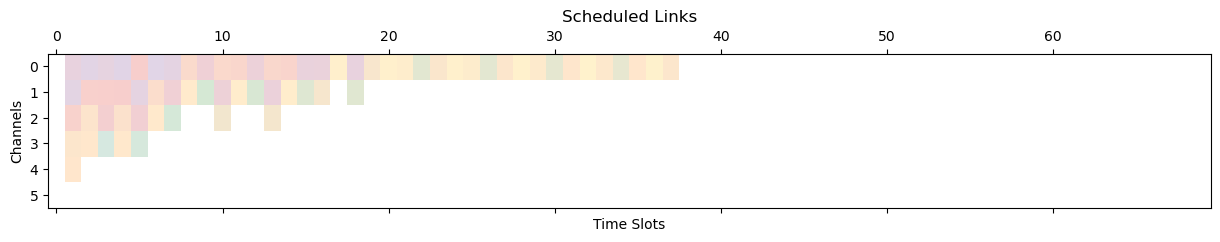

In [9]:
# print schedule

# init empty schedule
schedule = np.zeros((NUM_CHANNELS, NUM_TIMESLOTS))
links = []
link_n = 0

for node in nodes:
    # go through assigned timeslots for node
    for timeslot in node.timeslots:
        time = timeslot.time
        channel = timeslot.frequency
        if timeslot.type=='TS_RX':
            rx = node.id
            tx = timeslot.neighbor.id
        else: 
            rx = timeslot.neighbor.id
            tx = node.id
        # fill schedule with link
        schedule[channel, time] = link_n
        link_n += 1
        links += [[tx,rx]]

# Plotting the schedule as a heatmap
fig, ax = plt.subplots(figsize=(15, 2))
cax = ax.matshow(schedule, cmap=custom_cmap, aspect='auto')

plt.xlabel('Time Slots')
plt.ylabel('Channels')
plt.title('Scheduled Links')
plt.show()

# Creating a database
- input: traffic q for each node. given as a list.
- output: flattened schedule (NUM_CHANNELS*NUM_TIMESLOTS long). has 0s in unscheduled cells and the corresponding node number in a cell where that node is scheduled to tx.

In [10]:
import itertools

combinations = list(itertools.product(range(1,5), repeat=12))

random.seed(42)
random.shuffle(combinations)

In [11]:
len(combinations)

16777216

In [12]:
n_samples = 2000000

In [13]:
# create database
num_fails = 0

# Define the file path to save the HDF5 database
hdf5_file_path = 'database.h5'

with h5py.File(hdf5_file_path, 'w') as hf:

    for i in tqdm(range(n_samples)):
        combination = np.array(combinations[i])

        nodes = []

        # create nodes
        for n in range(NUM_NODES):
            if n==0:
                nodes+=[Node(n,0)]
            else:
                q = combination[n-1]
                nodes+=[Node(n,q)]

        # init network links
        links_list = [Link(nodes[1],nodes[0]),
                      Link(nodes[2],nodes[0]),
                      Link(nodes[3],nodes[0]),
                      Link(nodes[4],nodes[0]),
                      Link(nodes[5],nodes[1]),
                      Link(nodes[6],nodes[1]),
                      Link(nodes[7],nodes[2]),
                      Link(nodes[8],nodes[3]),
                      Link(nodes[9],nodes[3]),
                      Link(nodes[10],nodes[4]),
                      Link(nodes[11],nodes[5]),
                      Link(nodes[12],nodes[8])]

        # init network tree
        tree = init_network_tree(nodes, database=False)

        # create matrices
        interference_matrix = create_interference_matrix(links_list)
        conflict_matrix = create_conflict_matrix(interference_matrix, nodes)

        try:
            main_tasa(nodes,links_list,tree,interference_matrix,conflict_matrix,0, verbose=False)
        except:
            print('error')
            print(combination)
            num_fails += 1

        # init empty schedule
        schedule = np.zeros((NUM_CHANNELS, NUM_TIMESLOTS))

        for node in nodes:
            # go through assigned timeslots for node
            for timeslot in node.timeslots:
                time = timeslot.time
                channel = timeslot.frequency
                if timeslot.type=='TS_TX': # avoid repeating twice the same link (one side TX, other side RX, but same link)
                    rx = timeslot.neighbor.id
                    tx = node.id
                    # fill schedule with link
                    schedule[channel, time] = tx

        # store input - output sample
        input_data = combination
        output_data = schedule.flatten()

        # Create datasets or append to existing ones in HDF5 file
        if 'inputs' not in hf:
            hf.create_dataset('inputs', (n_samples, len(combination)), maxshape=(None, len(combination)), dtype=np.float32)
        if 'outputs' not in hf:
            hf.create_dataset('outputs', (n_samples, len(output_data)), maxshape=(None, len(output_data)), dtype=np.float32)

        hf['inputs'][i] = input_data
        hf['outputs'][i] = output_data

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [14]:
# visualize the HDF5 file
with h5py.File('database.h5', 'r') as hf:
    # Print the keys (names) of all datasets in the file
    print("Dataset Keys:", list(hf.keys()))

    # Access and print the shape of the 'inputs' and 'outputs' datasets
    inputs_shape = hf['inputs'].shape
    outputs_shape = hf['outputs'].shape
    print("Inputs Shape:", inputs_shape)
    print("Outputs Shape:", outputs_shape)

    # Access and print a sample from the 'inputs' and 'outputs' datasets
    sample_n = random.randint(1,n_samples)
    sample_input = hf['inputs'][sample_n]
    sample_output = hf['outputs'][sample_n]
    print("Sample Input:", sample_input)
    print("Sample Output:", sample_output)

Dataset Keys: ['inputs', 'outputs']
Inputs Shape: (2000000, 12)
Outputs Shape: (2000000, 420)
Sample Input: [2. 4. 4. 4. 3. 2. 3. 2. 2. 1. 2. 3.]
Sample Output: [ 0. 10. 12.  7. 12. 11.  5.  8.  6.  5.  9.  6.  3.  9.  2.  3.  4.  1.
  2.  3.  4.  1.  2.  3.  4.  1.  2.  3.  4.  1.  2.  3.  4.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 12.
  7. 11.  5.  8.  3.  1.  8.  3.  1.  8.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  5.  8.
  3.  1.  0.  0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [15]:
print(num_fails)

0
